## Empirical Example for RobustiPY (Type 5)!

 This example is designed to show how RobustiPy can be used with multiple dependent variables. In particular, it replicates the retracted [Gino et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/32551743/) study. See Data Colada's blog posts about it [here](https://datacolada.org/118).


### What did Study 3A do?

* **Design:** One‑factor, three‑condition, between‑subjects experiment run on U.S. MTurk workers (≈ 600 participants).
* **Conditions:**
  | Condition | 3‑minute writing prompt | Psychological frame |
  |-----------|------------------------|---------------------|
  | **Promotion** | “Write about your *hopes and aspirations* for the future.” | *Ideal‑self* → approach mindset |
  | **Prevention** | “Write about your *duties and obligations*—things you feel you *should* do.” | *Ought‑self* → avoidance mindset |
  | **Neutral control** | “Describe what you did yesterday.” | Baseline |
* **Task after prime:** Read a vignette about attending a professional‑networking reception.
* **Two outcome blocks (DVs):**
  1. **Moral impurity** — 7 adjectives (dirty, tainted, etc.) → averaged.
  2. **Networking intentions** — 4 items gauging willingness to network.

Authors reported an ordered effect (Prevention > Control > Promotion) on moral impurity—evidence that “networking feels dirtier when you’re focused on obligations.” That pattern later turned out to rely on a tampered CSV; the original Qualtrics export shows no such ordering.

---

## How are we using RobustiPY to revisit those claims?

1. **Load both datasets** — *posted* (tampered) vs. *original* (untouched).
2. **Bundle multiple DVs** so moral‑impurity *and* networking‑intention items are analysed together.
3. **Run RobustiPY’s Type‑5 pipeline** which fits a multivariate OLS across thousands of specifications and bootstrapped resamples—capturing the full garden‑of‑forking‑paths around controls, folds, and model choices.
4. **Visualise** the promotion‑vs‑prevention contrasts for each dataset/outcome bundle to see how robustness evaporates once the authentic data are used.

**Take‑home:** RobustiPY makes it painfully clear that the headline effect is fragile—and only survives in the doctored file—while also showing how quickly significance melts when you respect the correlation between multiple outcomes.


In [1]:
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from robustipy.models import OLSRobust
from robustipy.utils import get_colormap_colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

n_draws = 1000
import warnings
from robustipy.prototypes import MissingValueWarning

# Ignore all MissingValueWarning warnings from robustipy
warnings.filterwarnings(
    action="ignore",
    category=MissingValueWarning,
    module=r"robustipy\.prototypes"
)


n_draws = 1000

In [2]:
def download_and_unzip(url: str, output_dir: str) -> None:
    """
    Downloads a ZIP file from the specified URL and extracts its contents.

    Parameters:
    - url (str): The URL of the ZIP file.
    - output_dir (str): The directory where the extracted files will be placed.

    The function performs the following steps:
    1. Download the ZIP file, represented as a binary object Z.
    2. Create the output directory if it does not exist.
    3. Extract the contents of the ZIP file into output_dir.
    4. Remove the temporary ZIP file.
    """
    
    # Define a temporary filename for storing the downloaded ZIP file.
    zip_filename = "temp_download.zip"
    
    # Step 1: Download the file.
    print(f"Downloading file from {url} ...")
    try:
        urllib.request.urlretrieve(url, zip_filename)
        print("Download complete.")
    except Exception as e:
        print(f"An error occurred during download: {e}")
        return
    
    # Step 2: Ensure that the output directory exists.
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    else:
        print(f"Directory already exists: {output_dir}")
    
    # Step 3: Extract the ZIP file's contents.
    print(f"Extracting contents to {output_dir} ...")
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print("Extraction complete.")
    except zipfile.BadZipFile as e:
        print(f"Error: The downloaded file is not a valid zip file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during extraction: {e}")
    
    # Step 4: Clean up by removing the temporary ZIP file.
    try:
        os.remove(zip_filename)
        print("Temporary file removed.")
    except Exception as e:
        print(f"Warning: Could not remove the temporary file: {e}")

# Define the URL and the directory where the extracted contents will be stored.
zip_url = "https://s3.wasabisys.com/zipballs.researchbox.org/ResearchBox_3124.zip"
extraction_directory = "../data/gino_example/ResearchBox_3124_extracted"

# Execute the download and extraction process.
download_and_unzip(zip_url, extraction_directory)


Download complete.
Directory already exists: ../data/gino_example/ResearchBox_3124_extracted
Extracting contents to ../data/gino_example/ResearchBox_3124_extracted ...
Extraction complete.
Temporary file removed.


In [3]:
def figure_plotter(results_promo_published,
                   results_preven_published,
                   results_promo,
                   results_preven,
                   results_promo_published_wnet,
                   results_preven_published_wnet,
                   results_promo_wnet,
                   results_preven_wnet,
                   fig_name):

    colors = get_colormap_colors(4)
    plt.rcParams['font.family'] = 'Helvetica'
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    df1a = results_promo_published.summary_df.sort_values('median').reset_index(drop=True)
    df1b = results_preven_published.summary_df.sort_values('median').reset_index(drop=True)
    df2a = results_promo.summary_df.sort_values('median').reset_index(drop=True)
    df2b = results_preven.summary_df.sort_values('median').reset_index(drop=True)


    df3a = results_promo_published_wnet.summary_df.sort_values('median').reset_index(drop=True)
    df3b = results_preven_published_wnet.summary_df.sort_values('median').reset_index(drop=True)
    df4a = results_promo_wnet.summary_df.sort_values('median').reset_index(drop=True)
    df4b = results_preven_wnet.summary_df.sort_values('median').reset_index(drop=True)


    ax1.plot(df1a.index, df1a['median'], label='Promotion Condition', color=colors[0])
    ax1.fill_between(df1a.index, df1a['ci_down'], df1a['ci_up'], color=colors[0], alpha=0.15)
    ax1.plot(df1b.index, df1b['median'], label='Prevention Condition', color=colors[1])
    ax1.fill_between(df1b.index, df1b['ci_down'], df1b['ci_up'], color=colors[1], alpha=0.15)
    ax1.set_xlabel('Model Rank', fontsize=16)
    ax1.set_ylabel('Reconstructed Estimate\n(with Moral Impurity)', fontsize=16)
    ax1.set_title('a.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax1.spines['bottom'].set_position(('outward', 10))
    ax1.spines['left'].set_position(('outward', 10))
    ax1.legend()
    ax1.tick_params(labelsize=12)
    ax1.set_ylim(-0.6, 0.7)
    ax1.set_xlim(0, ax1.get_xlim()[1])
    ax1.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    ax2.plot(df2a.index, df2a['median'], label='Promotion Condition', color=colors[0])
    ax2.fill_between(df2a.index, df2a['ci_down'], df2a['ci_up'], color=colors[0], alpha=0.15)
    ax2.plot(df2b.index, df2b['median'], label='Prevention Condition', color=colors[1])
    ax2.fill_between(df2b.index, df2b['ci_down'], df2b['ci_up'], color=colors[1], alpha=0.15)
    ax2.set_ylabel('Published Estimate\n(with Moral Impurity)', fontsize=16)
    ax2.set_xlabel('Model Rank', fontsize=16)
    ax2.legend()
    ax2.spines['bottom'].set_position(('outward', 10))
    ax2.spines['left'].set_position(('outward', 10))
    ax2.set_title('b.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax2.tick_params(labelsize=12)
    ax2.set_ylim(-0.6, 0.7)
    ax2.set_xlim(0, ax2.get_xlim()[1])
    ax2.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    ax3.plot(df3a.index, df3a['median'], label='Promotion Condition', color=colors[0])
    ax3.fill_between(df3a.index, df3a['ci_down'], df3a['ci_up'], color=colors[0], alpha=0.15)
    ax3.plot(df3b.index, df3b['median'], label='Prevention Condition', color=colors[1])
    ax3.fill_between(df3b.index, df3b['ci_down'], df3b['ci_up'], color=colors[1], alpha=0.15)
    ax3.set_xlabel('Model Rank', fontsize=16)
    ax3.set_ylabel('Published Estimate\n(with Networking Intentions)', fontsize=16)
    ax3.set_title('c.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax3.spines['bottom'].set_position(('outward', 10))
    ax3.spines['left'].set_position(('outward', 10))
    ax3.legend()
    ax3.tick_params(labelsize=12)
    ax3.set_ylim(-0.6, 0.7)
    ax3.set_xlim(0, ax3.get_xlim()[1])
    ax3.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    ax4.plot(df4a.index, df4a['median'], label='Promotion Condition', color=colors[0])
    ax4.fill_between(df4a.index, df4a['ci_down'], df4a['ci_up'], color=colors[0], alpha=0.15)
    ax4.plot(df4b.index, df4b['median'], label='Prevention Condition', color=colors[1])
    ax4.fill_between(df4b.index, df4b['ci_down'], df4b['ci_up'], color=colors[1], alpha=0.15)
    ax4.set_xlabel('Model Rank', fontsize=16)
    ax4.set_ylabel('Reconstructed Estimate\n(with Networking Intentions)', fontsize=16)
    ax4.set_title('d.', loc='left', fontsize=18, y=1.025, x=-0.075)
    ax4.spines['bottom'].set_position(('outward', 10))
    ax4.spines['left'].set_position(('outward', 10))
    ax4.legend()
    ax4.tick_params(labelsize=12)
    ax4.set_ylim(-0.6, 0.7)
    ax4.set_xlim(0, ax3.get_xlim()[1])
    ax4.grid(True, axis='both', linestyle=(0, (2, 6)),
             linewidth=0.74, alpha=0.3, color='k', zorder=3)

    legend_elements2 = [Patch(facecolor=colors[0], edgecolor='k',
                              label=r'Promotion (CI)', alpha=0.7),
                        Line2D([0], [0], color=colors[0], lw=1, linestyle='-',
                               label=r'Promotion (Med.)', alpha=0.7),
                        Patch(facecolor=colors[1], edgecolor='k',
                              label=r'Prevention (CI)', alpha=0.7),
                        Line2D([0], [0], color=colors[1], lw=1, linestyle='-',
                               label=r'Prevention (Med.)', alpha=0.7)]
    ax2.legend(handles=legend_elements2, loc='upper right', frameon=True,
               fontsize=10, framealpha=1, facecolor='w', ncols=2,
               edgecolor=(0, 0, 0, 1),
               )

    ax1.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    
    plt.tight_layout()
    sns.despine()
    os.makedirs(os.path.join('..',
                         'figures',
                         'gino_example',
                        ),
            exist_ok=True
           )
    plt.savefig("../figures/gino_example/" + fig_name + '.pdf', bbox_inches='tight')
    plt.savefig("../figures/gino_example/" + fig_name + '.png', bbox_inches='tight', dpi=400)
    plt.savefig("../figures/gino_example/" + fig_name + '.svg', bbox_inches='tight')

In [4]:
box = '../data/gino_example/ResearchBox_3124_extracted/ResearchBox 3124/'
data = pd.read_csv(box + "Data/Gino et al. (2020) Study 3A Posted Data.csv")
corrected_data = pd.read_csv(box + "Data/Data Cleaned & Re-constructed.csv")

## Comparison using moral impurity items

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is promotion_Dummy. Let's begin the calculations...
Total model runs: 508,000 (draws=1000, control_specs=4, y_composites=127)


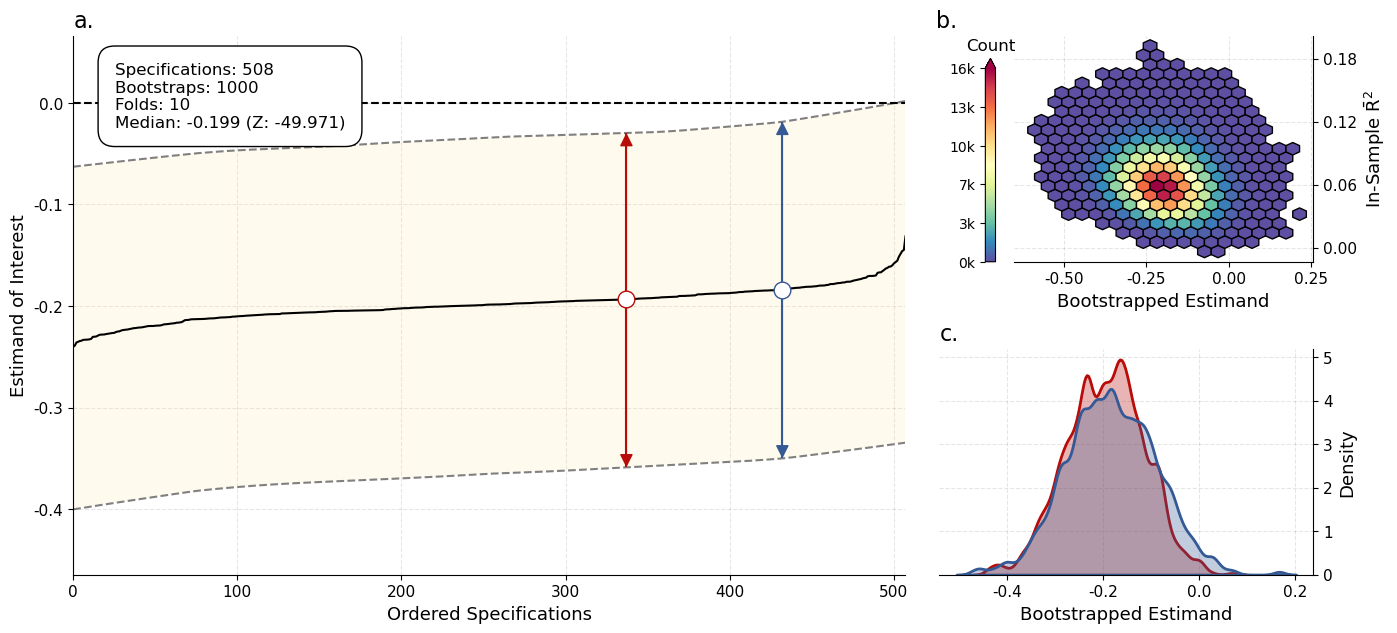

In [5]:
y = ['moralImpurity_1',
     'moralImpurity_2',
     'moralImpurity_3',
     'moralImpurity_4',
     'moralImpurity_5',
     'moralImpurity_6',
     'moralImpurity_7']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
z = ['age',
     'male']

gino_promo_published = OLSRobust(y=y, x=x, data=data)
gino_promo_published.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_promo_published = gino_promo_published.get_results()
gino_results_promo_published.plot(ic='hqic',
                                  ext='pdf',
                                  ci=0.95,
                                  loess=True,
                                  project_name='gino_results_promo_published',
                                  figpath = '../figures',
                                  figsize=(16, 7)
                                 )

In [6]:
gino_results_promo_published.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'moralImpurity_4', 'moralImpurity_5', 'moralImpurity_7', 'moralImpurity_3', 'moralImpurity_6', 'moralImpurity_1', 'moralImpurity_2'}
Independent variable: ['promotion_Dummy', 'prevention_dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 508
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): -0.20 (null-calibrated p: 0)
Median β (bootstraps × specs): -0.20
Min β (specs, no resampling): -0.24
Min β (bootstraps × specs): -0.61
Max β (specs, no resampling): -0.14
Max β (bootstraps × specs): 0.22
Share significant (specs, no resampling) [descriptive]: 0.93
Share significant (bootstraps × specs) [descriptive]: 0.61  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.00
Share β>0 (bootstraps × specs) [descriptive]: 0.01  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]:

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the rmse metric.
The estimand of interest is prevention_dummy. Let's begin the calculations...
Total model runs: 508,000 (draws=1000, control_specs=4, y_composites=127)


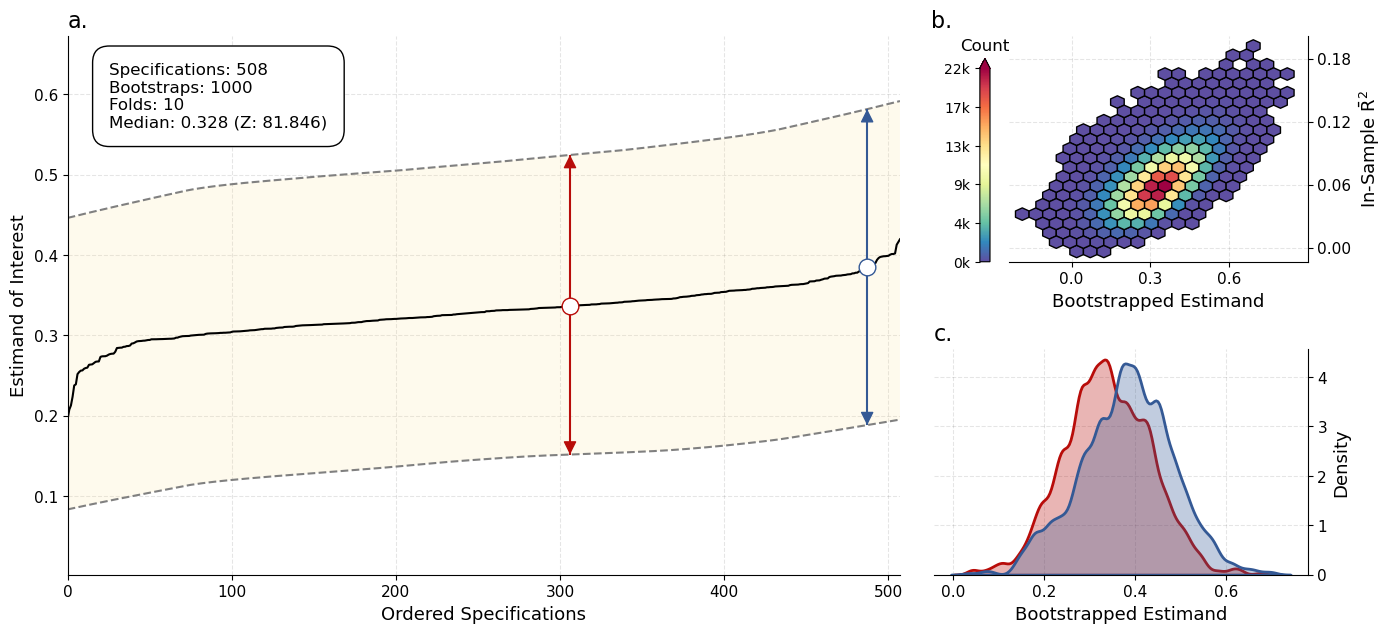

In [7]:
y = ['moralImpurity_1',
     'moralImpurity_2',
     'moralImpurity_3',
     'moralImpurity_4',
     'moralImpurity_5',
     'moralImpurity_6',
     'moralImpurity_7']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_preven_published = OLSRobust(y=y, x=x, data=data)
gino_preven_published.fit(controls=z, draws=n_draws, oos_metric='rmse', kfold=10, seed=192733)
gino_results_preven_published = gino_preven_published.get_results()
gino_results_preven_published.plot(ic='hqic',
                                   ext='pdf',
                                   ci=0.95,
                                   loess=True,
                                   project_name='gino_results_preven_published',
                                   figpath = '../figures',
                                   figsize=(16, 7)
                                  )

In [8]:
gino_results_preven_published.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'moralImpurity_4', 'moralImpurity_5', 'moralImpurity_7', 'moralImpurity_3', 'moralImpurity_6', 'moralImpurity_1', 'moralImpurity_2'}
Independent variable: ['prevention_dummy', 'promotion_Dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 508
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): 0.33 (null-calibrated p: 0)
Median β (bootstraps × specs): 0.33
Min β (specs, no resampling): 0.20
Min β (bootstraps × specs): -0.19
Max β (specs, no resampling): 0.42
Max β (bootstraps × specs): 0.85
Share significant (specs, no resampling) [descriptive]: 1.00
Share significant (bootstraps × specs) [descriptive]: 0.93  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 1.00
Share β>0 (bootstraps × specs) [descriptive]: 1.00  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.0

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is promotion_Dummy. Let's begin the calculations...
Total model runs: 508,000 (draws=1000, control_specs=4, y_composites=127)


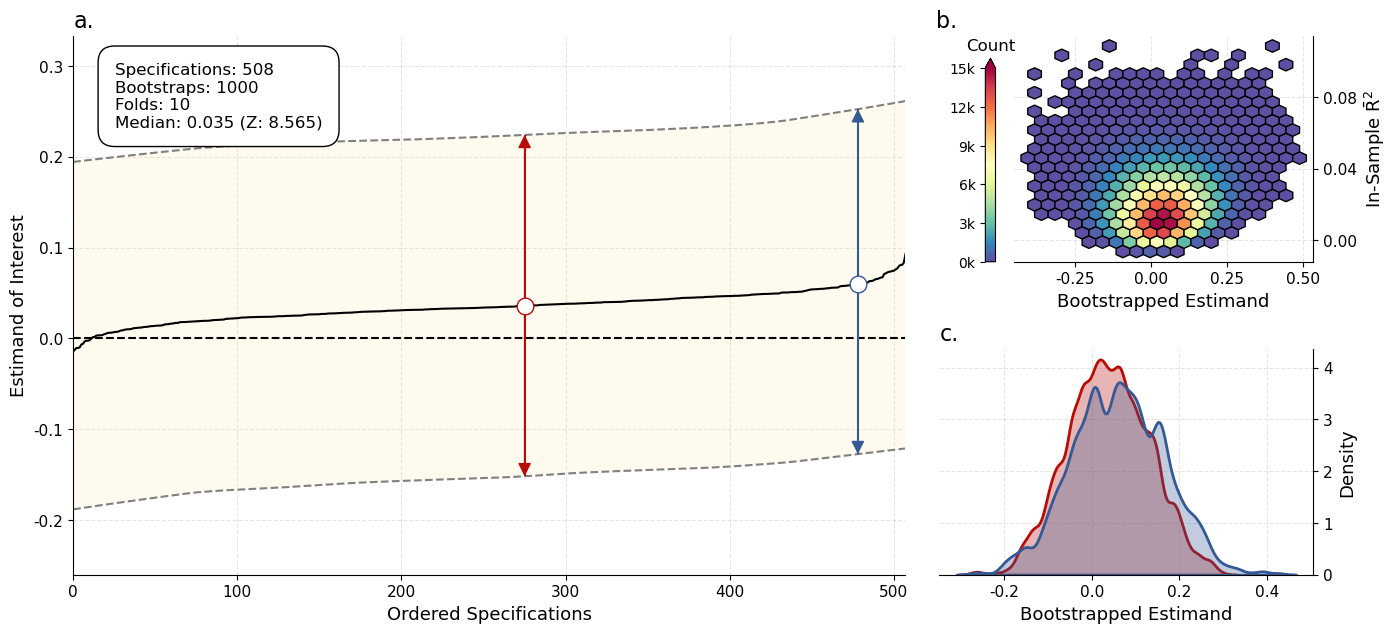

In [9]:
y = ['dirty_orig',
     'tainted_orig',
     'inauthentic_orig',
     'ashamed_orig',
     'wrong_orig',
     'unnatural_orig',
     'impure_orig']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
c= ['age',
    'male']

gino_promo = OLSRobust(y=y, x=x, data=corrected_data)
gino_promo.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_promo = gino_promo.get_results()
gino_results_promo.plot(ic='hqic',
                        ext='pdf',
                        ci=0.95,
                        loess=True,
                        project_name='gino_results_promo',
                        figpath = '../figures',
                        figsize=(16, 7)
                       )

In [10]:
gino_results_promo.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'inauthentic_orig', 'tainted_orig', 'wrong_orig', 'unnatural_orig', 'impure_orig', 'dirty_orig', 'ashamed_orig'}
Independent variable: ['promotion_Dummy', 'prevention_dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 508
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): 0.03 (null-calibrated p: 0)
Median β (bootstraps × specs): 0.03
Min β (specs, no resampling): -0.01
Min β (bootstraps × specs): -0.41
Max β (specs, no resampling): 0.09
Max β (bootstraps × specs): 0.49
Share significant (specs, no resampling) [descriptive]: 0.00
Share significant (bootstraps × specs) [descriptive]: 0.08  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.98
Share β>0 (bootstraps × specs) [descriptive]: 0.64  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.02
Share β<0 (bootst

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is prevention_dummy. Let's begin the calculations...
Total model runs: 508,000 (draws=1000, control_specs=4, y_composites=127)


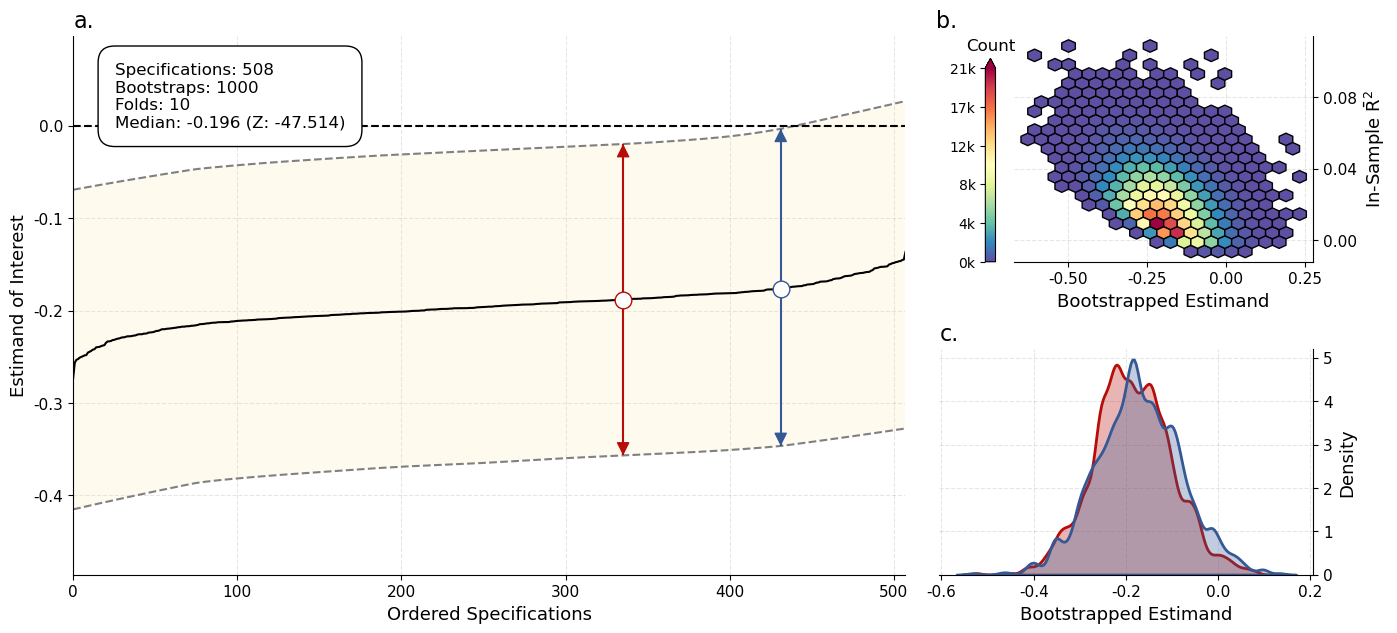

In [11]:
y = ['dirty_orig',
     'tainted_orig',
     'inauthentic_orig',
     'ashamed_orig',
     'wrong_orig',
     'unnatural_orig',
     'impure_orig']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
    ]
c= ['age',
    'male']

gino_preven = OLSRobust(y=y, x=x, data=corrected_data)
gino_preven.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_preven = gino_preven.get_results()
gino_results_preven.plot(ic='hqic',
                         ext='pdf',
                         ci=0.95,
                         loess=True,
                         project_name='gino_results_preven',
                         figpath = '../figures',
                         figsize=(16, 7)
                        )

In [12]:
gino_results_preven.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'inauthentic_orig', 'tainted_orig', 'wrong_orig', 'unnatural_orig', 'impure_orig', 'dirty_orig', 'ashamed_orig'}
Independent variable: ['prevention_dummy', 'promotion_Dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 508
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): -0.20 (null-calibrated p: 0)
Median β (bootstraps × specs): -0.20
Min β (specs, no resampling): -0.27
Min β (bootstraps × specs): -0.63
Max β (specs, no resampling): -0.14
Max β (bootstraps × specs): 0.23
Share significant (specs, no resampling) [descriptive]: 0.79
Share significant (bootstraps × specs) [descriptive]: 0.57  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.00
Share β>0 (bootstraps × specs) [descriptive]: 0.02  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 1.00
Share β<0 (boo

## Comparison Using Networking Intention Items

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is promotion_Dummy. Let's begin the calculations...
Total model runs: 60,000 (draws=1000, control_specs=4, y_composites=15)


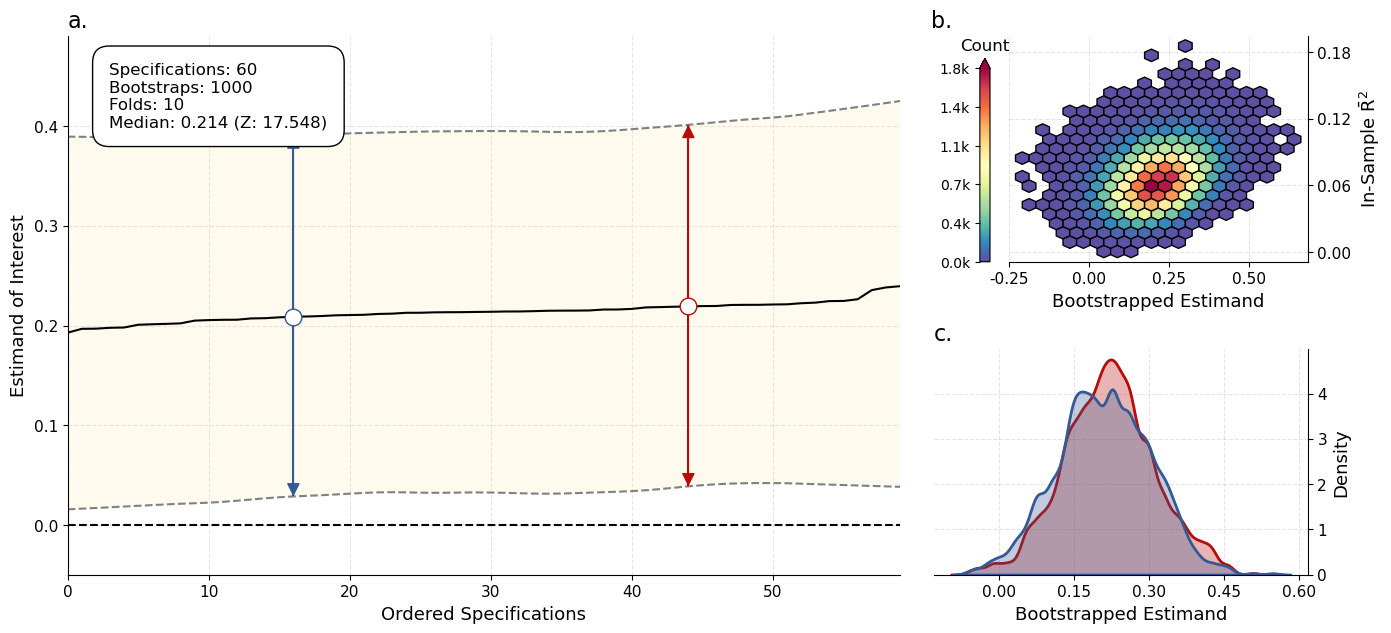

In [13]:
y = ['netIntentions_1',
     'netIntentions_2',
     'netIntentions_3',
     'netIntentions_4']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
z = ['age',
     'male']

gino_promo_published_wnet = OLSRobust(y=y, x=x, data=data)
gino_promo_published_wnet.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_promo_published_wnet = gino_promo_published_wnet.get_results()
gino_results_promo_published_wnet.plot(ic='hqic',
                                       ext='pdf',
                                       ci=0.95,
                                       loess=True,
                                       project_name='gino_results_promo_published_wnet',
                                       figpath = '../figures',
                                       figsize=(16, 7)
                                      )

In [14]:
gino_results_promo_published_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'netIntentions_1', 'netIntentions_4', 'netIntentions_2', 'netIntentions_3'}
Independent variable: ['promotion_Dummy', 'prevention_dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 60
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): 0.21 (null-calibrated p: 0)
Median β (bootstraps × specs): 0.21
Min β (specs, no resampling): 0.20
Min β (bootstraps × specs): -0.21
Max β (specs, no resampling): 0.24
Max β (bootstraps × specs): 0.64
Share significant (specs, no resampling) [descriptive]: 1.00
Share significant (bootstraps × specs) [descriptive]: 0.62  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 1.00
Share β>0 (bootstraps × specs) [descriptive]: 0.99  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 0.00
Share β<0 (bootstraps × specs) [descriptive]: 0.01  |  n

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is prevention_dummy. Let's begin the calculations...
Total model runs: 60,000 (draws=1000, control_specs=4, y_composites=15)


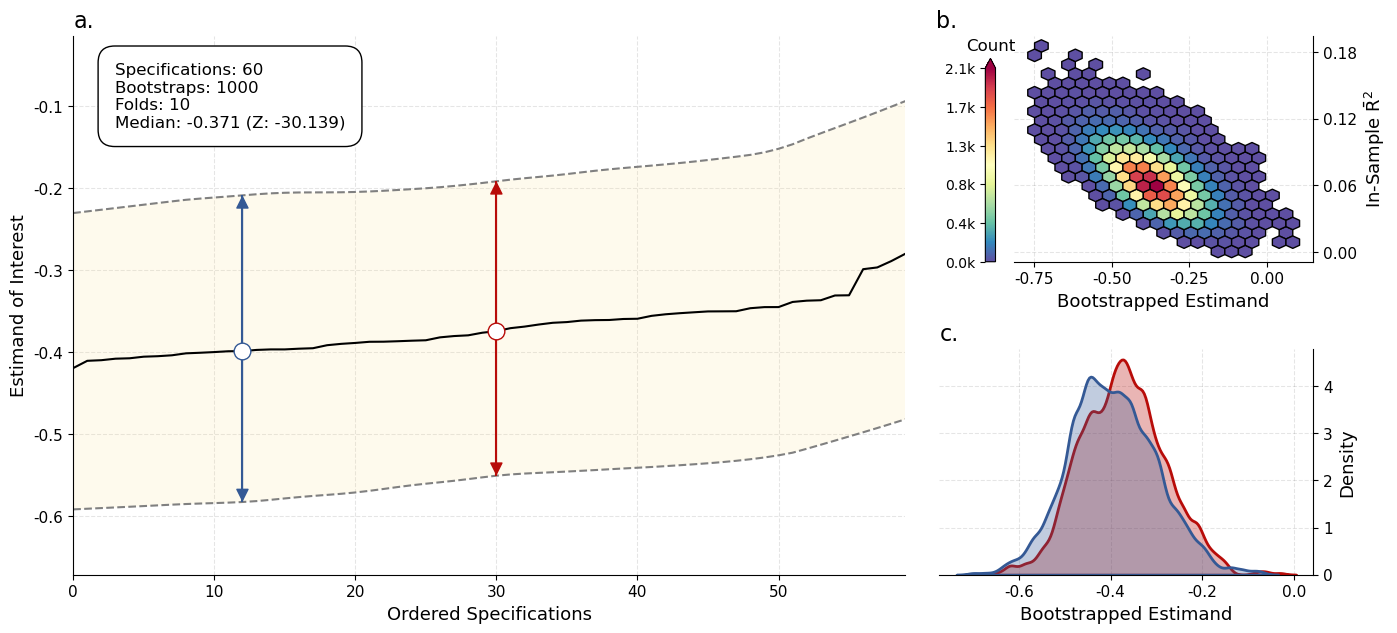

In [15]:
y = ['netIntentions_1',
     'netIntentions_2',
     'netIntentions_3',
     'netIntentions_4']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
     ]
z = ['age',
     'male']

gino_preven_published_wnet = OLSRobust(y=y, x=x, data=data)
gino_preven_published_wnet.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_preven_published_wnet = gino_preven_published_wnet.get_results()
gino_results_preven_published_wnet.plot(ic='hqic',
                                        ext='pdf',
                                        ci=0.95,
                                        loess=True,
                                        project_name='gino_results_preven_published_wnet',
                                        figpath = '../figures',
                                        figsize=(16, 7)
                                       )

In [16]:
gino_results_preven_published_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'netIntentions_1', 'netIntentions_4', 'netIntentions_2', 'netIntentions_3'}
Independent variable: ['prevention_dummy', 'promotion_Dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 60
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): -0.37 (null-calibrated p: 0)
Median β (bootstraps × specs): -0.37
Min β (specs, no resampling): -0.41
Min β (bootstraps × specs): -0.77
Max β (specs, no resampling): -0.28
Max β (bootstraps × specs): 0.11
Share significant (specs, no resampling) [descriptive]: 1.00
Share significant (bootstraps × specs) [descriptive]: 0.97  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.00
Share β>0 (bootstraps × specs) [descriptive]: 0.00  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 1.00
Share β<0 (bootstraps × specs) [descriptive]: 1.00  

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is promotion_Dummy. Let's begin the calculations...
Total model runs: 60,000 (draws=1000, control_specs=4, y_composites=15)


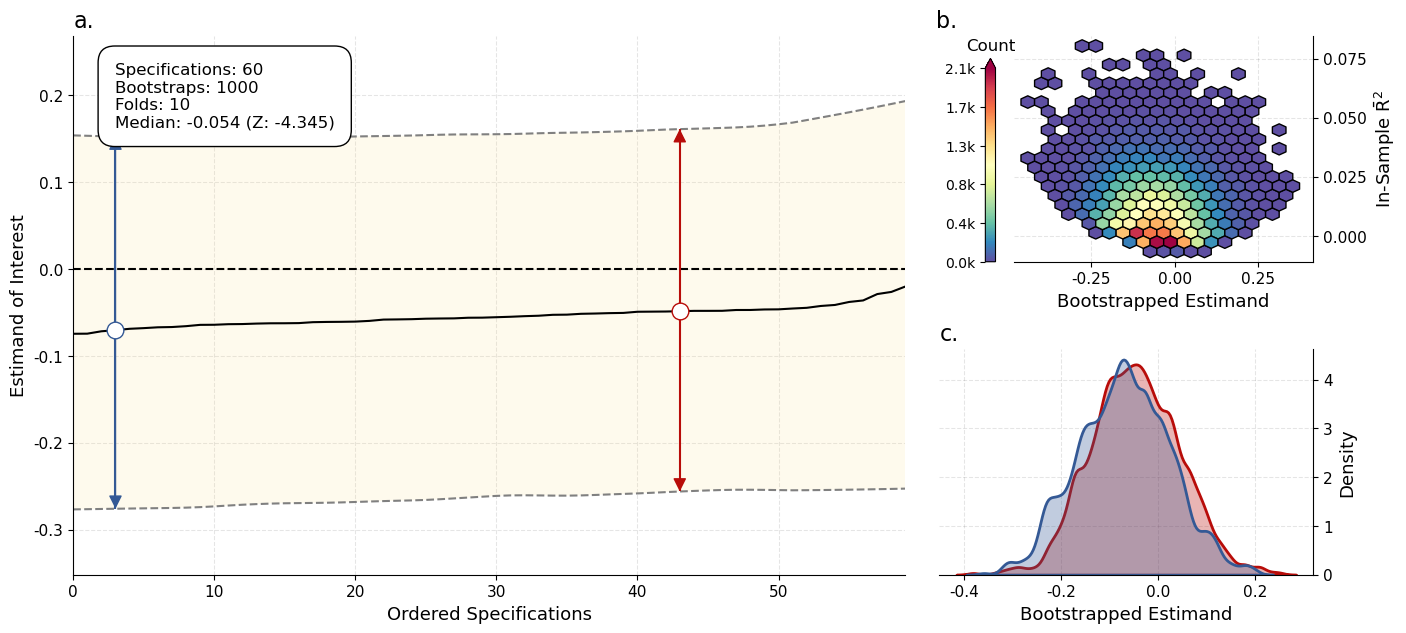

In [17]:
y = ['net_intent1_orig',
     'net_intent2_orig',
     'net_intent3_orig',
     'net_intent4_orig']
x = [
    'promotion_Dummy',
    'prevention_dummy',
    #'control_Dummy'
     ]
z = ['age',
     'male']

gino_promo_wnet = OLSRobust(y=y, x=x, data=corrected_data)
gino_promo_wnet.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_promo_wnet = gino_promo_wnet.get_results()
gino_results_promo_wnet.plot(ic='hqic',
                             ext='pdf',
                             ci=0.975,
                             loess=True,
                             project_name='gino_results_promo_wnet',
                             figpath = '../figures',
                             figsize=(16, 7)
                            )

In [18]:
gino_results_promo_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'net_intent3_orig', 'net_intent2_orig', 'net_intent4_orig', 'net_intent1_orig'}
Independent variable: ['promotion_Dummy', 'prevention_dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 60
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): -0.06 (null-calibrated p: 0.001)
Median β (bootstraps × specs): -0.05
Min β (specs, no resampling): -0.07
Min β (bootstraps × specs): -0.44
Max β (specs, no resampling): -0.03
Max β (bootstraps × specs): 0.38
Share significant (specs, no resampling) [descriptive]: 0.00
Share significant (bootstraps × specs) [descriptive]: 0.08  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.00
Share β>0 (bootstraps × specs) [descriptive]: 0.28  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 1.00
Share β<0 (bootstraps × specs) [descriptive]

In [19]:
y = ['net_intent1_orig',
     'net_intent2_orig',
     'net_intent3_orig',
     'net_intent4_orig']
x = [
    'prevention_dummy',
    'promotion_Dummy',
    #'control_Dummy'
     ]
z = ['age',
     'male']

gino_preven_wnet = OLSRobust(y=y, x=x, data=corrected_data)
gino_preven_wnet.fit(controls=z, draws=n_draws, oos_metric='pseudo-r2', kfold=10, seed=192733)
gino_results_preven_wnet = gino_preven_wnet.get_results()

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

Calculating Composite Ys
OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192733.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is prevention_dummy. Let's begin the calculations...
Total model runs: 60,000 (draws=1000, control_specs=4, y_composites=15)


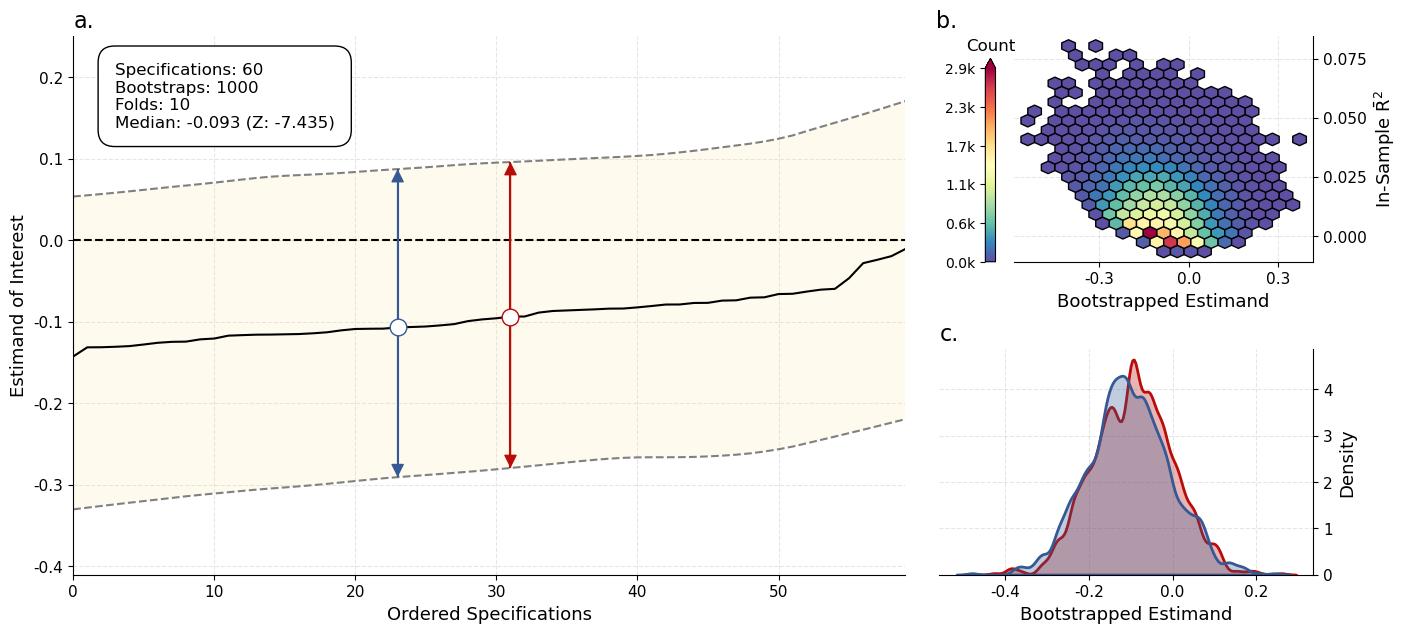

In [20]:
gino_results_preven_wnet.plot(ic='hqic',
                              ext='pdf',
                              ci=0.95,
                              loess=True,
                              project_name='gino_results_preven_wnet',
                              figpath = '../figures',
                              figsize=(16, 7)
                             )

In [21]:
gino_results_preven_wnet.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'net_intent3_orig', 'net_intent2_orig', 'net_intent4_orig', 'net_intent1_orig'}
Independent variable: ['prevention_dummy', 'promotion_Dummy', 'const']
Number of possible controls: 2
Number of draws: 1000
Number of folds: 10
Number of specifications: 60
2.Model Robustness Metrics
2.1 Inference Metrics
Median β (specs, no resampling): -0.09 (null-calibrated p: 0)
Median β (bootstraps × specs): -0.09
Min β (specs, no resampling): -0.14
Min β (bootstraps × specs): -0.54
Max β (specs, no resampling): -0.01
Max β (bootstraps × specs): 0.37
Share significant (specs, no resampling) [descriptive]: 0.00
Share significant (bootstraps × specs) [descriptive]: 0.17  |  null-calibrated p: 0.002
Share β>0 (specs, no resampling) [descriptive]: 0.00
Share β>0 (bootstraps × specs) [descriptive]: 0.18  |  null-calibrated p: 0.002
Share β<0 (specs, no resampling) [descriptive]: 1.00
Share β<0 (bootstraps × specs) [descriptive]: 0.

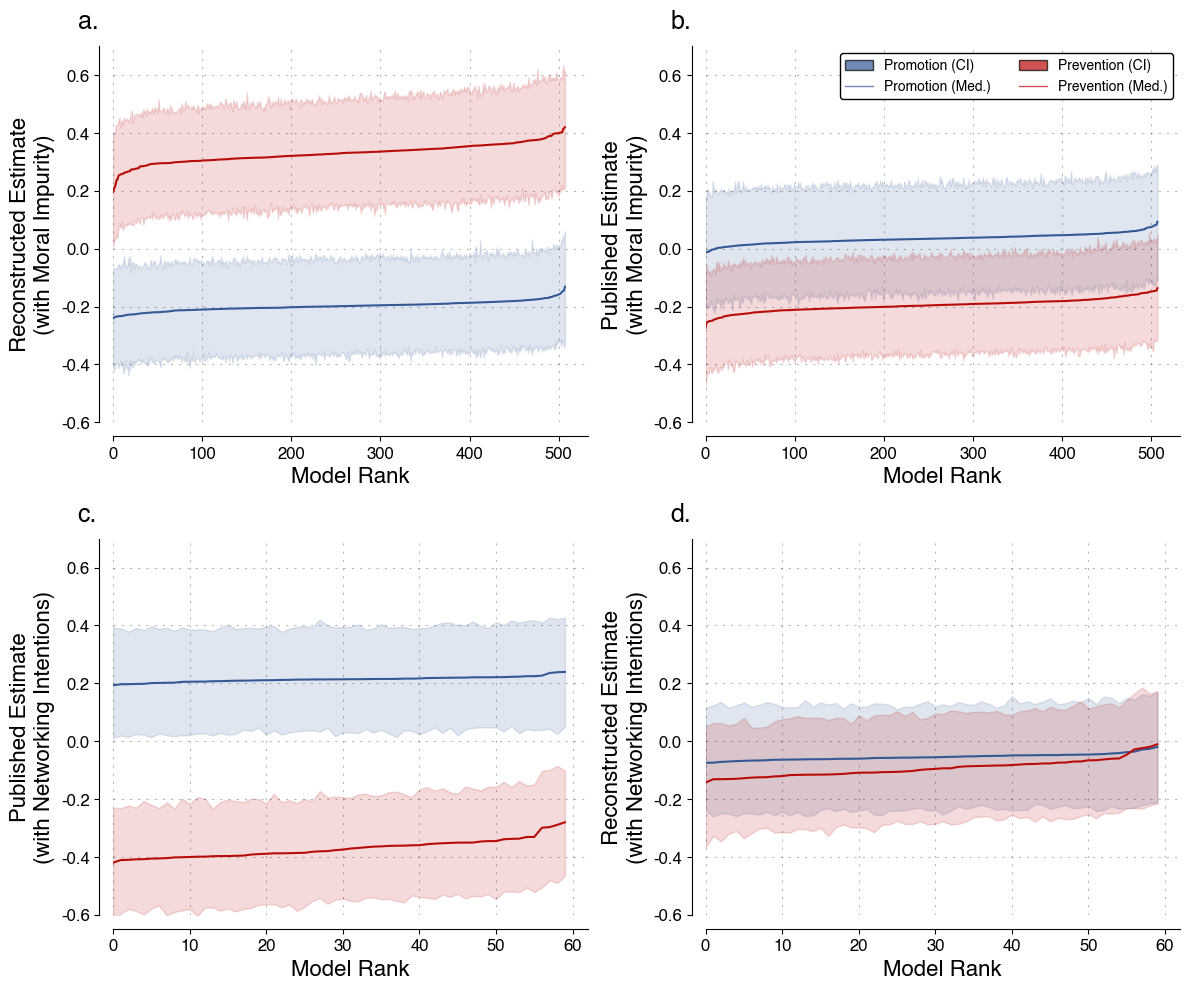

In [22]:
figure_plotter(gino_results_promo_published,
               gino_results_preven_published,
               gino_results_promo,
               gino_results_preven,
               gino_results_promo_published_wnet,
               gino_results_preven_published_wnet,
               gino_results_promo_wnet,
               gino_results_preven_wnet,
               'gino_figure')